In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pymongo as pm
from bson.objectid import ObjectId
from collections import defaultdict, Counter
import mmh3
import itertools
import datetime
import json
import seaborn as sns
import enchant

In [2]:
def get_connection():
    con = pm.Connection()
    db = con.heroku_rnwkcq9r
    return db

db = get_connection()

# Is negative feedback rated as less constructive?

In [342]:
# Main data structure to write to
ds = defaultdict(lambda: defaultdict(list))

# Book keeping for normalization
handins = defaultdict(list)
assignments = defaultdict(list)
courses = defaultdict(list)

# For printing progress
increments = np.arange(0, length_of_collection, length_of_collection/10)

length_of_collection = db['answer'].find({"numerical_answer": {"$exists": True}}).count()

c = -1
for t in db['answer'].find({"numerical_answer": {"$exists": True}}):
    
    c += 1  # Progress counter
    if c in increments:
        print str(list(increments).index(c) * 10) + "%",
    
    # Question pertaining to answer in loop
    question = list(db['question'].find({"_id": t["question"]}))[0]
    
    # Not all questions have numerical answers. Skip the ones that doesn't
    if not "numericalAnswers" in question:
        continue
    
    normalized_score = \
        t['numerical_answer'] * 1.0 / \
        max(map(int, question['numericalAnswers'].keys()))
    
    # Handle incomplete data
    try:
        report_grade = list(db['report_grade'].find({"_id": t['report_grade']}))[0]
    except IndexError:
        # document doesn't exist in report_grade
        continue
    
    # Some gradings don't have feedback grades
    if not "feedback_grade" in report_grade:
        continue
        
    giver_handin = str(report_grade['giver']) + str(report_grade['handin'])
    
    ds[giver_handin]['normalized_scores'].append(normalized_score)
    ds[giver_handin]['feedback_grade'] = report_grade['feedback_grade']
    
    # For later normalization wrt. different stuff
    course = list(db['assignment'].find({"_id": report_grade['assignment']}))[0]['course']
    
    ds[giver_handin]['handin'] = report_grade['handin']
    ds[giver_handin]['assignment'] = report_grade['assignment']
    ds[giver_handin]['course'] = course
    
    assignments[report_grade['assignment']].append(normalized_score)
    handins[report_grade['handin']].append(normalized_score)
    courses[course].append(normalized_score)

0% 10% 20% 30% 40% 50% 60% 70% 80% 90%


### Raw scores

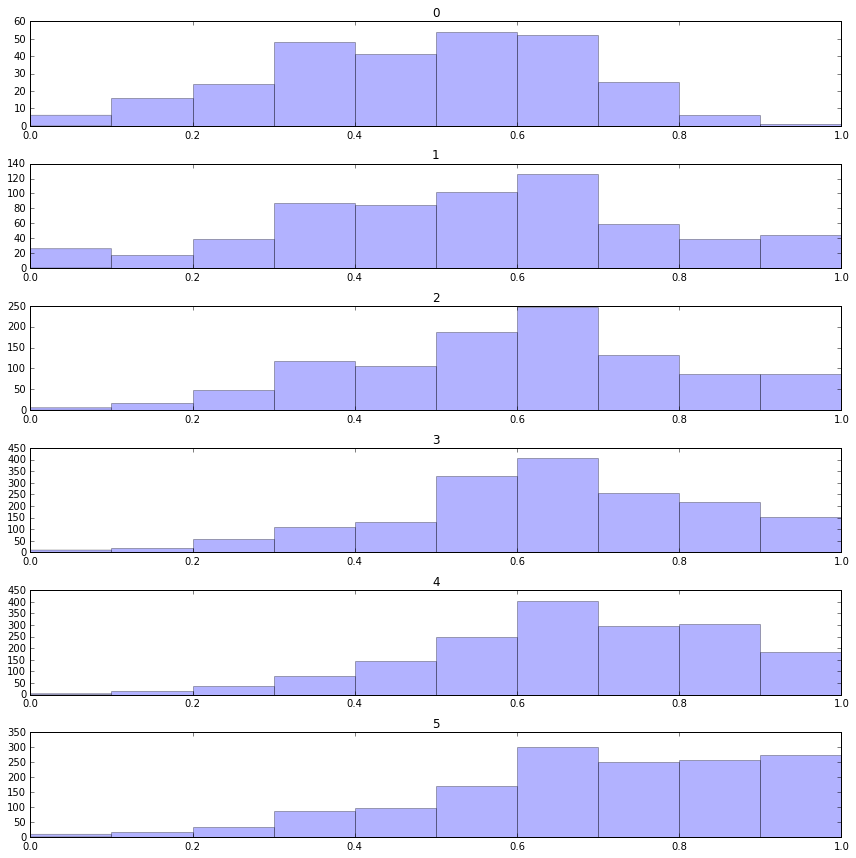

In [169]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(np.mean(v['normalized_scores']))
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(v)
    plt.hist(h, alpha=0.3)
plt.tight_layout()
plt.show()

### Normalized by assignment mean

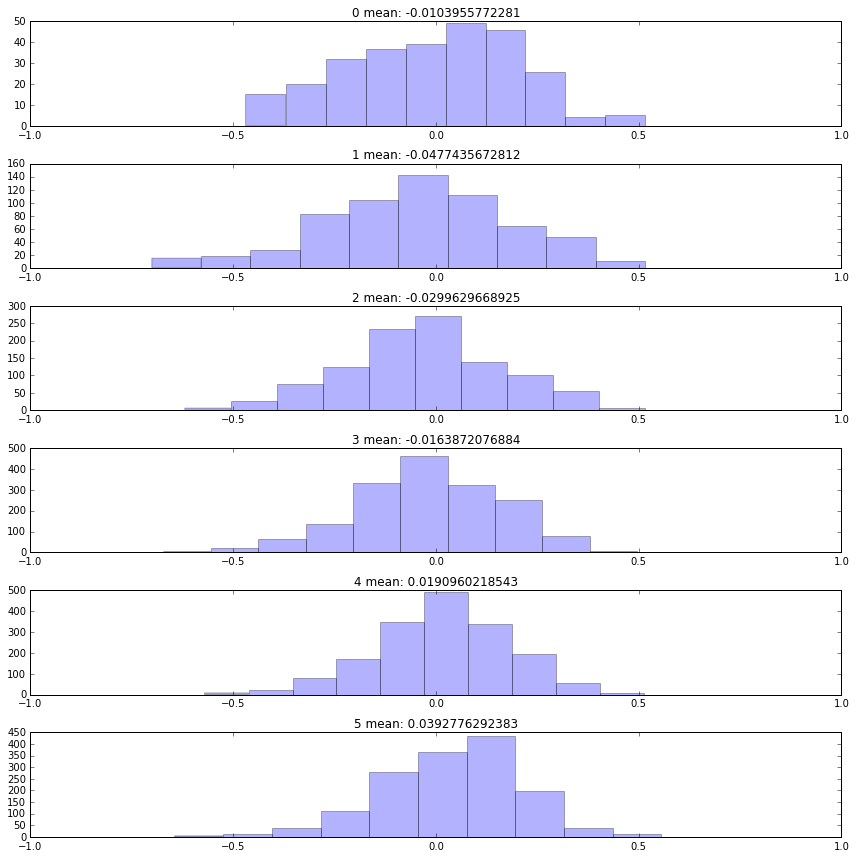

In [197]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(assignments[v['assignment']])
    )
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(str(v) + " mean: " + str(np.mean(h)))
    plt.hist(h, alpha=0.3)
    plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

### Normalized by course mean

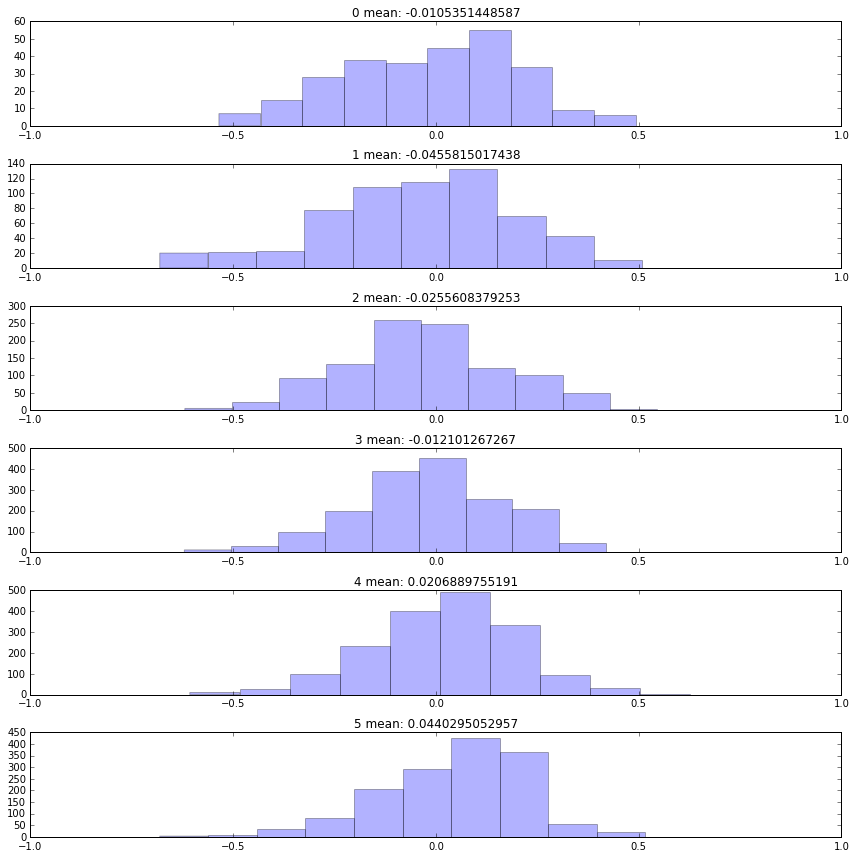

In [227]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(courses[v['course']])
    )
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(str(v) + " mean: " + str(np.mean(h)))
    plt.hist(h, alpha=0.3)
    plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

### Normalized by handin

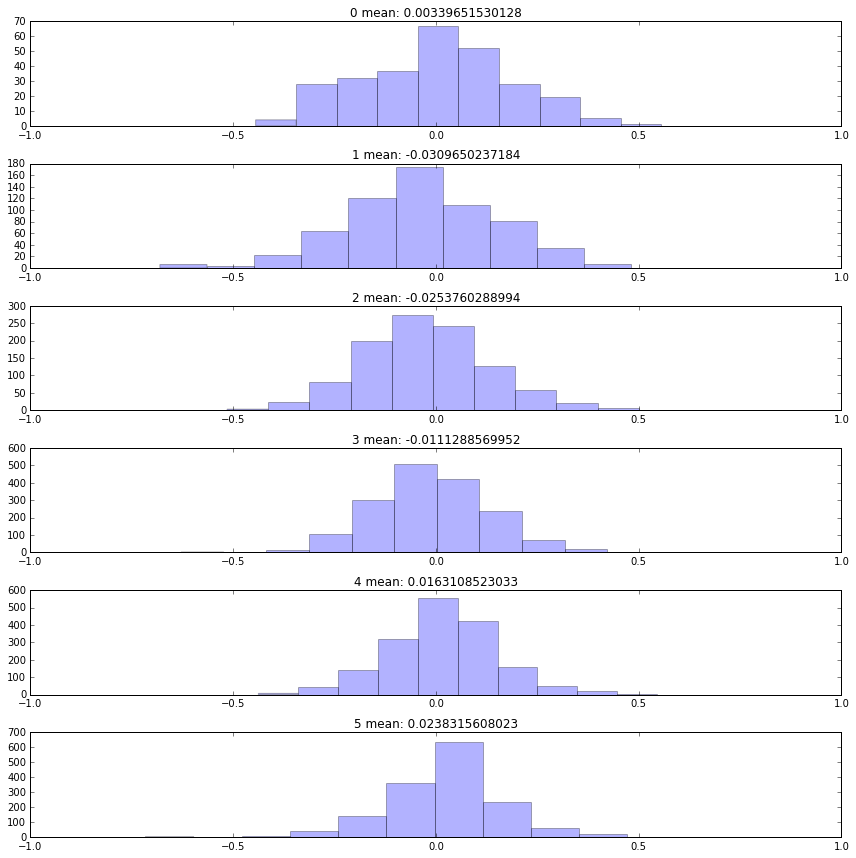

In [229]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(handins[v['handin']])
    )
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(str(v) + " mean: " + str(np.mean(h)))
    plt.hist(h, alpha=0.3)
    plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

# Does group work pull performance towards average?

This code will need to look in the dictionaries 'handins' and 'assignments'. If it does not exist, write some code to make it, or be lazy and execute the first major cell in the chapter above.

In [344]:
ds = defaultdict(list)
for handin in db['handin'].find():
    
    if not 'students' in handin:
        continue
    if not handin['_id'] in handins:  # NEEDS TO EXIST
        continue
    if not handin['assignment'] in assignments:  # NEEDS TO EXIST
        continue
        
    for student in handin['students']:
        ds[student].append(
            (
                len(handin['students']),
                np.mean(handins[handin['_id']]) - np.mean(assignments[handin['assignment']])
            )
        )

In [346]:
x, y = [], []
for _, v in ds.items():
    for t in v:
        x.append(t[0]+np.random.rand(1)[0])
        y.append(t[1])

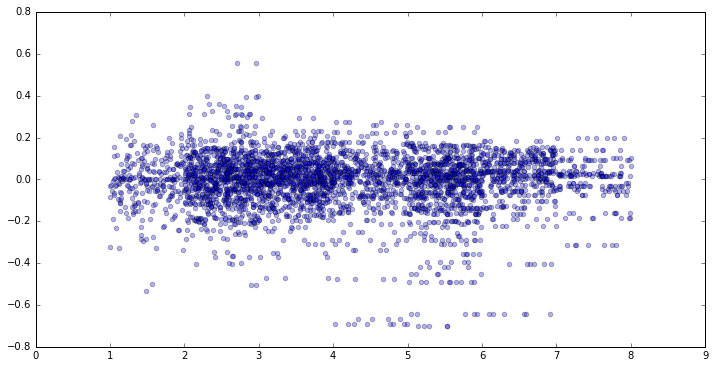

In [348]:
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.3)
plt.show()

In [350]:
# Filter out all dudes that only occur in one group size
for u, h in ds.items():
    if len(set([v[0] for v in h])) == 1:
        del ds[u]

/Users/ulfaslak/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


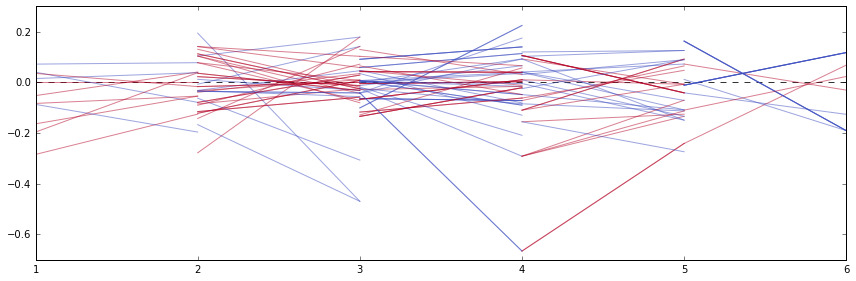

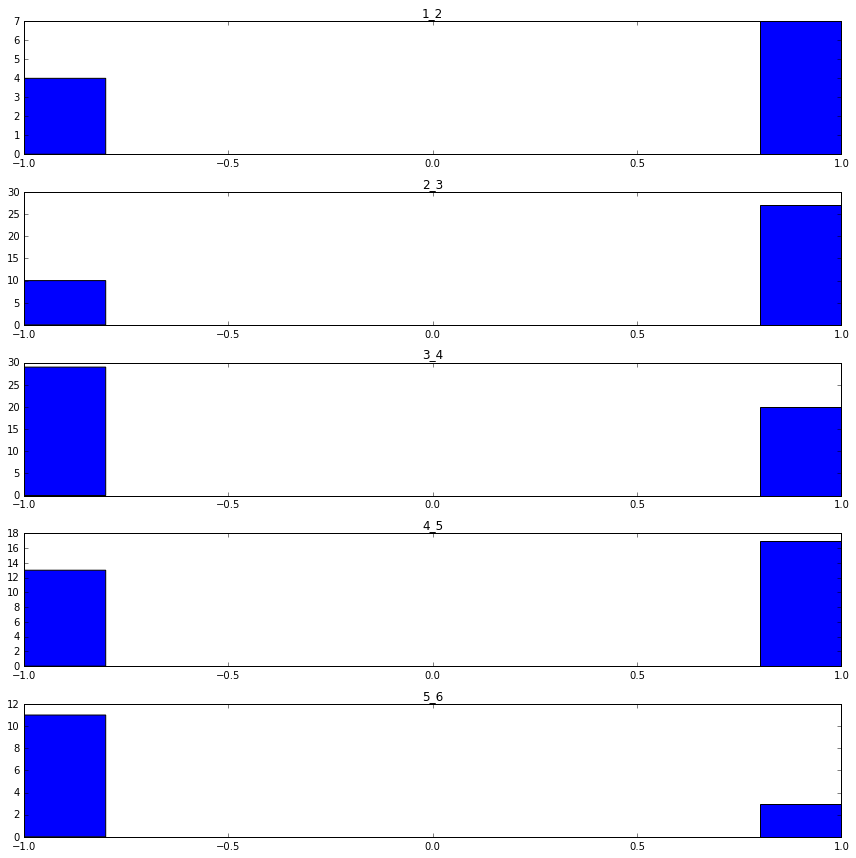

In [491]:
def sigmoid(x):
    return (1.0/(1+np.exp(-x+4)) - 0.5)*2

# Data for hisogram
improvement_hist = defaultdict(list)

# Colors
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.coolwarm
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(12,4))
plt.plot([1, 6], [0, 0], color="k", alpha=0.8, ls="--")

for _, v in ds.items():  # Loop through groups of assignments pertaining to individual users
    
    # Kind of an annoying way to do something simlple but who cares
    v_avg = defaultdict(list)
    for i, j in v:
        v_avg[i].append(j)
    
    for i, j in v_avg.items():
        v_avg[i] = np.mean(j)
    
    v = sorted(v_avg.items(), key=lambda t: t[0])  # Lowest group sizes first
    
    for a1 in v:  # Loop through pairs of assignments in each group
        for a2 in v:
            
            if a2[0] != a1[0] + 1:  # Only put an edge if size difference is one
                continue
            
            # Color
            improvement = simple(abs(a1[1]) / abs(a2[1]))
            improvement_hist[str(a1[0]) + "_" + str(a2[0])].append(improvement)
            c = list(m.to_rgba(improvement))
            c[-1] = 0.5
            
            plt.plot([a1[0], a2[0]], [a1[1], a2[1]], color=tuple(c))

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
for i, (title, hist) in enumerate(sorted(improvement_hist.items(), key=lambda x: x[0])):
    plt.subplot(5, 1, 1+i)
    plt.title(title)
    plt.hist([im for im in hist if not np.isnan(im)])

plt.tight_layout()
plt.show()

The largest effect seems to happen between group size 2 and 3.

/Users/ulfaslak/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in double_scalars


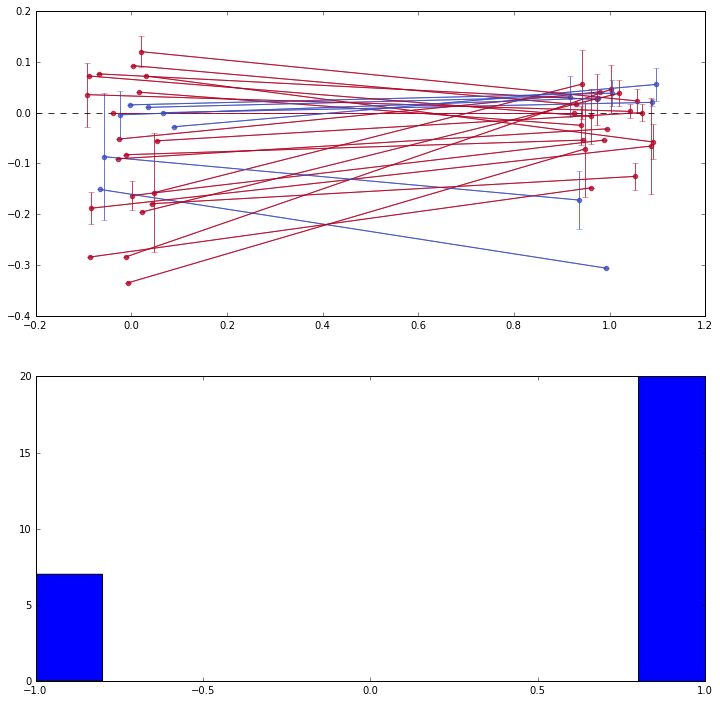

In [494]:
def sigmoid(x):
    return (1.0/(1+np.exp(-x+4)) - 0.5)*2

def simple(x):
    return -1 if x < 1 else 1

# Data for histogram
improvement_hist = []

# Data for computing p-value
alone_means = []
group_means = []

# Colors
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.coolwarm
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot
plt.figure(figsize=(12,12))

plt.subplot(2, 1, 1)
plt.plot([-0.2, 1.2], [0, 0], color="k", alpha=0.8, ls="--")

for _, v in ds.items():  # Loop through groups of assignments pertaining to individual users
    
    v = sorted(v, key=lambda t: t[0])  # Lowest group sizes first
    
    if v[0][0] != 1:
        continue
    
    alone = []
    group = []
    
    for a in v:
        if a[0] == 1:
            alone.append(a[1])
        else:
            group.append(a[1])
        
    alone_mean = np.mean(alone); alone_means.append(alone_mean)
    group_mean = np.mean(group); group_means.append(group_mean)
    
    alone_err = np.std(alone) / np.sqrt(len(alone))
    group_err = np.std(group) / np.sqrt(len(group))
    
    # Color
    improvement = simple(abs(alone_mean) / abs(group_mean))
    improvement_hist.append(improvement)
    c = list(m.to_rgba(improvement))
    c[-1] = 0.75
    
    alone_xpos = 0 + (np.random.rand(1)[0]-0.5)/5
    group_xpos = 1 + (np.random.rand(1)[0]-0.5)/5
    
    plt.plot([alone_xpos, group_xpos], [alone_mean, group_mean], color=tuple(c))
    plt.scatter([alone_xpos, group_xpos], [alone_mean, group_mean], color=tuple(c))
    plt.errorbar([alone_xpos, group_xpos], [alone_mean, group_mean], yerr=[alone_err, group_err], color=tuple(c))

    #plt.ylim([-0.4, 0.15])
    plt.xlim([-0.2, 1.2])
        
plt.subplot(2, 1, 2)
plt.hist(improvement_hist)

plt.show()

### Significance testing

Shuffle all the points (those in figure above) completely, to get new random points in domain, then check how many times random connections between those give better of equal averaging effect.

In [590]:
group_means_arr = np.array(map(abs, group_means))
alone_means_arr = np.array(map(abs, alone_means))

truth = Counter([
    -1 if i < 0 else 1 
    for i in group_means_arr - alone_means_arr
])[-1]

p_counter = []
for _ in range(100000):
    means_arr = np.hstack([alone_means_arr, group_means_arr])
    np.random.shuffle(means_arr)
    
    shuffled_alone_means_arr = means_arr[:len(means_arr)/2]
    shuffled_group_means_arr = means_arr[len(means_arr)/2:]

    random = Counter([
        -1 if i < 0 else 1 
        for i in shuffled_group_means_arr - shuffled_alone_means_arr
    ])[-1]
    
    p_counter.append(1 if random >= truth else 0)
    
print "p-value:", np.mean(p_counter)

p-value: 0.0247


# Attention capacity

Here I analyse a number of metrics that roughly translate to *good* or *poor* peergrading efforts as functions if how loaded the reviewer's capacity is. **The goal is to understand where to draw a reasonable limit** for how much reviewing work each students can be expected to do, such as to minimize poor peergrading due to attention deficiency.

### Construct datastructure

    ds = [
    {
        user_id : {
            meta : {},
            assignments : {
                assignment_id : {
                    course_id : str,
                    course_name : str,
                    handins : {
                        handin_id : {
                            started_at : timestamp,
                            submitted_at : timestamp,
                            time_spent : int,
                            flagged : bool,
                            state : str,
                            report_grade_id : ObjectId,
                            answers : {
                                answer_id : {
                                    numerical_answer : float,
                                    text_answer : str
                                },
                                ...
                            },
                            ...
                        }
                    }
                },
                ...
            }
        },
        ...
    },
    ...
    ]

In [25]:
def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d

def _flagged(answer):
    if "flagged" in answer:
        if answer['flagged']:
            return True
        else:
            return False
    else:
        return False

In [193]:
# Main
ds = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))))

# Aux
#ds_assignments = defaultdict(lambda: defaultdict(list))
ds_handins = defaultdict(lambda: defaultdict(list))


startdate = datetime.datetime.strptime("2015-08-01", '%Y-%m-%d')

faulty = []

# stats for stats
time_spent_pool = []
#end_start_pool = []
state_pool = []

query_rg = {
    "submitted_at": {"$exists": True},
    #"started_at": {"$exists": True},
    "time_spent": {"$exists": True},
    "flagged": {"$exists": True},
    "giver": {"$exists": True},
    "assignment": {"$exists": True},
    "handin": {"$exists": True}
}

for rg in db['report_grade'].find(query_rg):
    
    found_answers = False
    
    if rg["_id"].generation_time.replace(tzinfo=None) < startdate:
        tmp1.append(int((rg["_id"].generation_time).strftime("%s")))
        continue

    answer_scores = []
    comment_lengths = []
    
    # [main]
    user_id = rg['giver']
    assignment_id = rg['assignment']
    handin_id = rg['handin']
    course_id = str(db['assignment'].find({"_id": ObjectId(assignment_id)}).next()['course'])
    course_name = unicode(db['course'].find({"_id": ObjectId(course_id)}).next()['title'])
    
    # Answer data
    query_answer = {
        "report_grade" : rg['_id'],
        "numerical_answer" : {"$exists": True},
        "text_answer" : {"$exists": True}
    }
    
    for answer in db['answer'].find(query_answer):
        answer_scores.append(
            answer['numerical_answer'] * 1.0 / \
            max(map(int, db['question'].find({'_id': answer['question']}).next()['numericalAnswers'].keys()))
        )
        comment_lengths.append(len(answer['text_answer']))
        ds[str(user_id)]['assignments'][str(assignment_id)]['handins'][str(handin_id)]['answers'][str(answer['_id'])] = {
            "numerical_answer" : answer_scores[-1],
            "text_answer": answer['text_answer'],
            "flagged": _flagged(answer)
        }
        
        found_answers = True
        
    if not found_answers: 
        continue

    # Meta data [main]
    #ds[str(user_id)]['assignments'][str(assignment_id)]['handins'][str(handin_id)]['started_at'] = rg['started_at'].strftime("%s")
    ds[str(user_id)]['assignments'][str(assignment_id)]['handins'][str(handin_id)]['submitted_at'] = rg['submitted_at'].strftime("%s")
    ds[str(user_id)]['assignments'][str(assignment_id)]['handins'][str(handin_id)]['time_spent'] = rg['time_spent']
    ds[str(user_id)]['assignments'][str(assignment_id)]['handins'][str(handin_id)]['flagged'] = rg['flagged']
    ds[str(user_id)]['assignments'][str(assignment_id)]['handins'][str(handin_id)]['report_grade_id'] = str(rg['_id'])

    ds[str(user_id)]['assignments'][str(assignment_id)]['course_id'] = course_id
    ds[str(user_id)]['assignments'][str(assignment_id)]['course_name'] = course_name
    
    # [assignments]
    ds_handins[str(handin_id)]['score'].append(np.mean(answer_scores))
    ds_handins[str(handin_id)]['time_spent'].append(rg['time_spent'])
    ds_handins[str(handin_id)]['comment_length'].append(np.mean(comment_lengths))
    
    # stats for stats
    time_spent_pool.append(rg['time_spent'])
    #end_start_pool.append(int(rg['submitted_at'].strftime("%s")) - int(rg['started_at'].strftime("%s")))
    state_pool.append(rg['state'])
    
ds = default_to_regular(ds)
ds_handins = default_to_regular(ds_handins)

In [172]:
ds_handins

{'57e8239ec7052f005497226b': {'score': [0.33333333333333331],
  'time_spent': [3197]},
 '57deca694b67700010d02f91': {'score': [0.2857142857142857,
   0.66666666666666663,
   0.43333333333333329],
  'time_spent': [3880, 1358, 2861]},
 '56d0b04c6e0834000f91fc1c': {'score': [0.5], 'time_spent': [1100]},
 '57d6ab01b3162e0010477522': {'score': [0.94444444444444431,
   0.77777777777777768,
   0.77777777777777768],
  'time_spent': [962, 1300, 2727]},
 '57de24431bbcca0011dc6f4a': {'score': [1.0], 'time_spent': [1128]},
 '56c71e337aeb22000f139424': {'score': [0.66666666666666663],
  'time_spent': [1684]},
 '5710ecdff1b7f90021c173c3': {'score': [0.69999999999999996],
  'time_spent': [1612]},
 '57bec69e67e4df000fd9e6f8': {'score': [0.69047619047619058,
   0.66666666666666663],
  'time_spent': [1109, 2415]},
 '56d30518788d5a001516545e': {'score': [0.66666666666666663],
  'time_spent': [690]},
 '57ded75e4b67700010d02fc2': {'score': [0.33333333333333331,
   0.29166666666666663,
   0.0,
   0.0],
  't

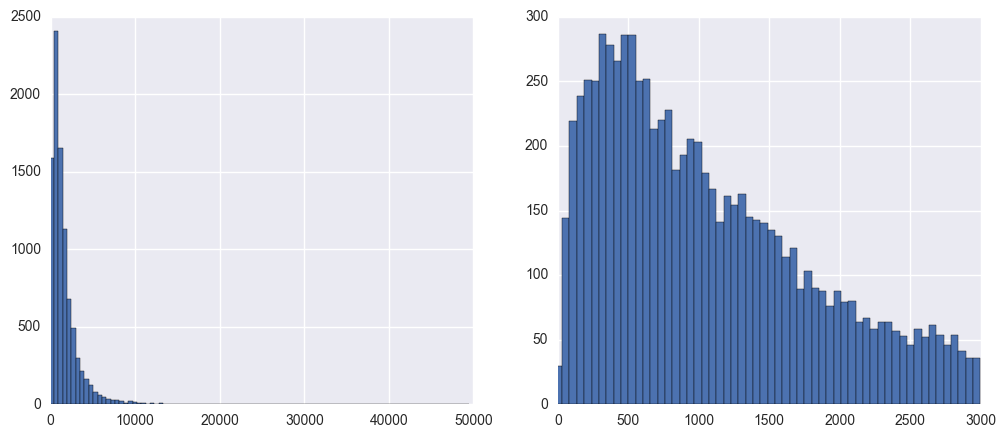

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(np.array([t for t in time_spent_pool if t < 50000]), bins=100)
#plt.xscale("log")
#plt.yscale("log")
plt.xlim([0, 50000])
plt.subplot(122)
plt.hist(np.array([t for t in time_spent_pool if t < 3000]), bins=100)
#plt.xscale("log")
#plt.yscale("log")
plt.xlim([0, 3000])
plt.show()

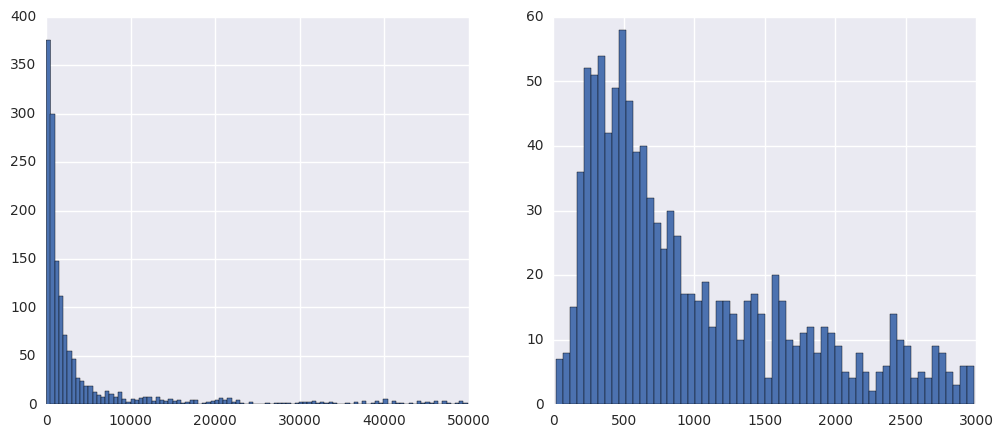

In [178]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(np.array([t for t in end_start_pool if t < 50000]), bins=100)
#plt.xscale("log")
#plt.yscale("log")
plt.xlim([0, 50000])
plt.subplot(122)

plt.hist(np.array([t for t in end_start_pool if t < 3000]), bins=60)
#plt.xscale("log")
#plt.yscale("log")
plt.xlim([0, 3000])
plt.show()

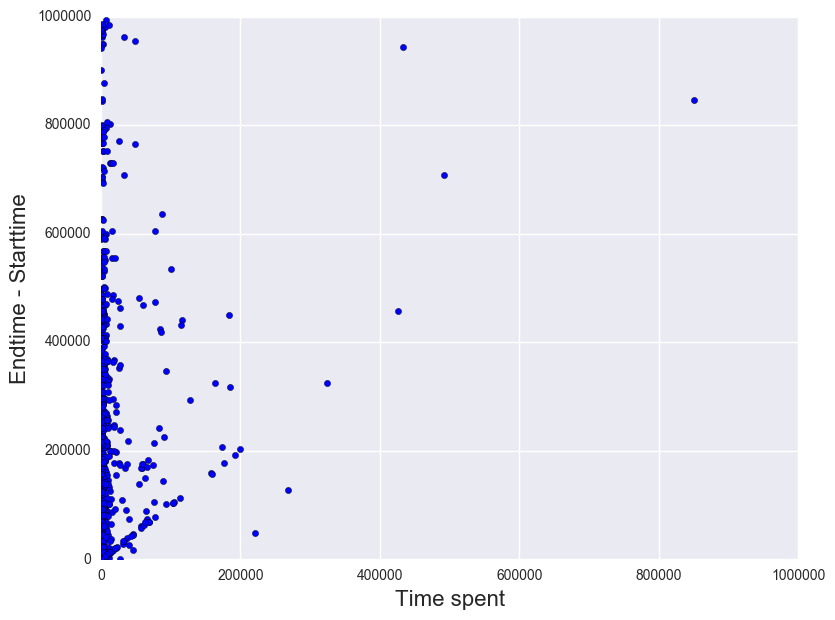

In [179]:
plt.figure(figsize=(9, 7))
plt.scatter(time_spent_pool, end_start_pool)
plt.xlabel("Time spent", fontsize=16)
plt.ylabel("Endtime - Starttime", fontsize=16)
plt.xlim([0, 1e6])
plt.ylim([0, 1e6])
plt.show()

Difference between endtime and starttime mostly exceeds 'time_spent' which means that 'time_spent' is probably the result of some javascript background process measuring more accurately how much time the user spends correcting the homework. In only 5% of the cases are time_spend values greater than endtime - starttime. **Moving forward only 'time_spent' will be used**.

In [183]:
print "Fraction of times that 'time_spent' exceeds endtime - starttime:", 
print np.mean([1 if a > b else 0 for a, b in zip(time_spent_pool, end_start_pool)])

Fraction of times that 'time_spent' exceeds endtime - starttime: 0.0588235294118


## Tendency to accompany perfect rating with comment

### Independent variable is # in reviewing sequence

In [44]:
handins['handins']

['570ea139fab37f000fe31918', '570e729cfab37f000fe31836']

In [71]:
course_activity = Counter()

for user_id, assignments in ds.items():
    for assignment_id, handins in assignments['assignments'].items():
        course_activity.update([handins['course_name'] for _ in handins['handins'].items()])
        
for course_name, count in course_activity.most_common(10):
    print count, " "*(5-len(str(count))), course_name

1254   42430 Project Management
1038   02105+02326 Algoritmer og Datastrukturer
578    41312 Fluid Mekanik (E16)
555    Introduction to the Philosophy of Science and Research Methodology for Computer Scientists
479    02807 Computational Tools for Big Data E16
398    Econometrics II
397    41312 Fluid Mekanik
337    02454 Introduction to Cognitive Science
322    5030-B4-4F16;Elektromagnetisme
317    Introduction to the Philosophy of Science and Research Methodology


In [208]:
d_en = enchant.Dict("en_US")

course = "42430 Project Management"

def is_capital(c):
    return c == c.upper()

def percentage_misspelled(sentence):
    return np.mean([not d_en.check(w) for w in sentence.split()])

x1 = defaultdict(list)
x2 = defaultdict(list)
x3 = defaultdict(list)
x4 = defaultdict(list)
x5 = defaultdict(list)
x6 = defaultdict(list)
x7 = defaultdict(list)

for user_id, assignments in ds.items():
    for assignment_id, handins in assignments['assignments'].items():
        if handins['course_name'] != course:
            break
        sorted_handins = sorted(handins['handins'].items(), key=lambda t: int(t[1]['submitted_at']))
        for i, (handin_id, answers) in enumerate(sorted_handins):
            
            numerical_answer = []
            text_answer_capitalized = []
            text_answer_length = []
            text_answer_fraction_misspelled = []
            answer_flagged = []
            
            for answer_id, answer in answers['answers'].items():
                numerical_answer.append(answer['numerical_answer'])
                text_answer_capitalized.append(1 if is_capital(answer['text_answer'][0]) else 0)
                text_answer_length.append(len(answer['text_answer']))
                text_answer_fraction_misspelled.append(percentage_misspelled(answer["text_answer"]))
                answer_flagged.append(answer['flagged'])
                
            x1[i+1].append(
                np.mean(numerical_answer) * 1.0 / \
                np.mean(ds_handins[str(handin_id)]['score'])
            )
            x2[i+1].append(
                handins['handins'][handin_id]['time_spent'] * 1.0 / \
                np.mean(ds_handins[str(handin_id)]['time_spent'])
            )
            x3[i+1].append(
                np.mean(text_answer_capitalized)
            )
            x4[i+1].append(
                np.mean(text_answer_length) * 1.0 / \
                np.mean(ds_handins[str(handin_id)]['comment_length'])
            )
            x5[i+1].append(
                np.mean(answer_flagged)
            )
            x6[i+1].append(
                np.mean(text_answer_fraction_misspelled)
            )

In [155]:
print "Datapoints: " + ", ".join(["%d" % len(v) for k, v in x1.items()])

Datapoints: 4350, 3027, 1762, 110, 31, 3, 2, 2, 1


In [209]:
print "Datapoints: " + ", ".join(["%d" % len(v) for k, v in x1.items()])

Datapoints: 563, 421, 142, 2


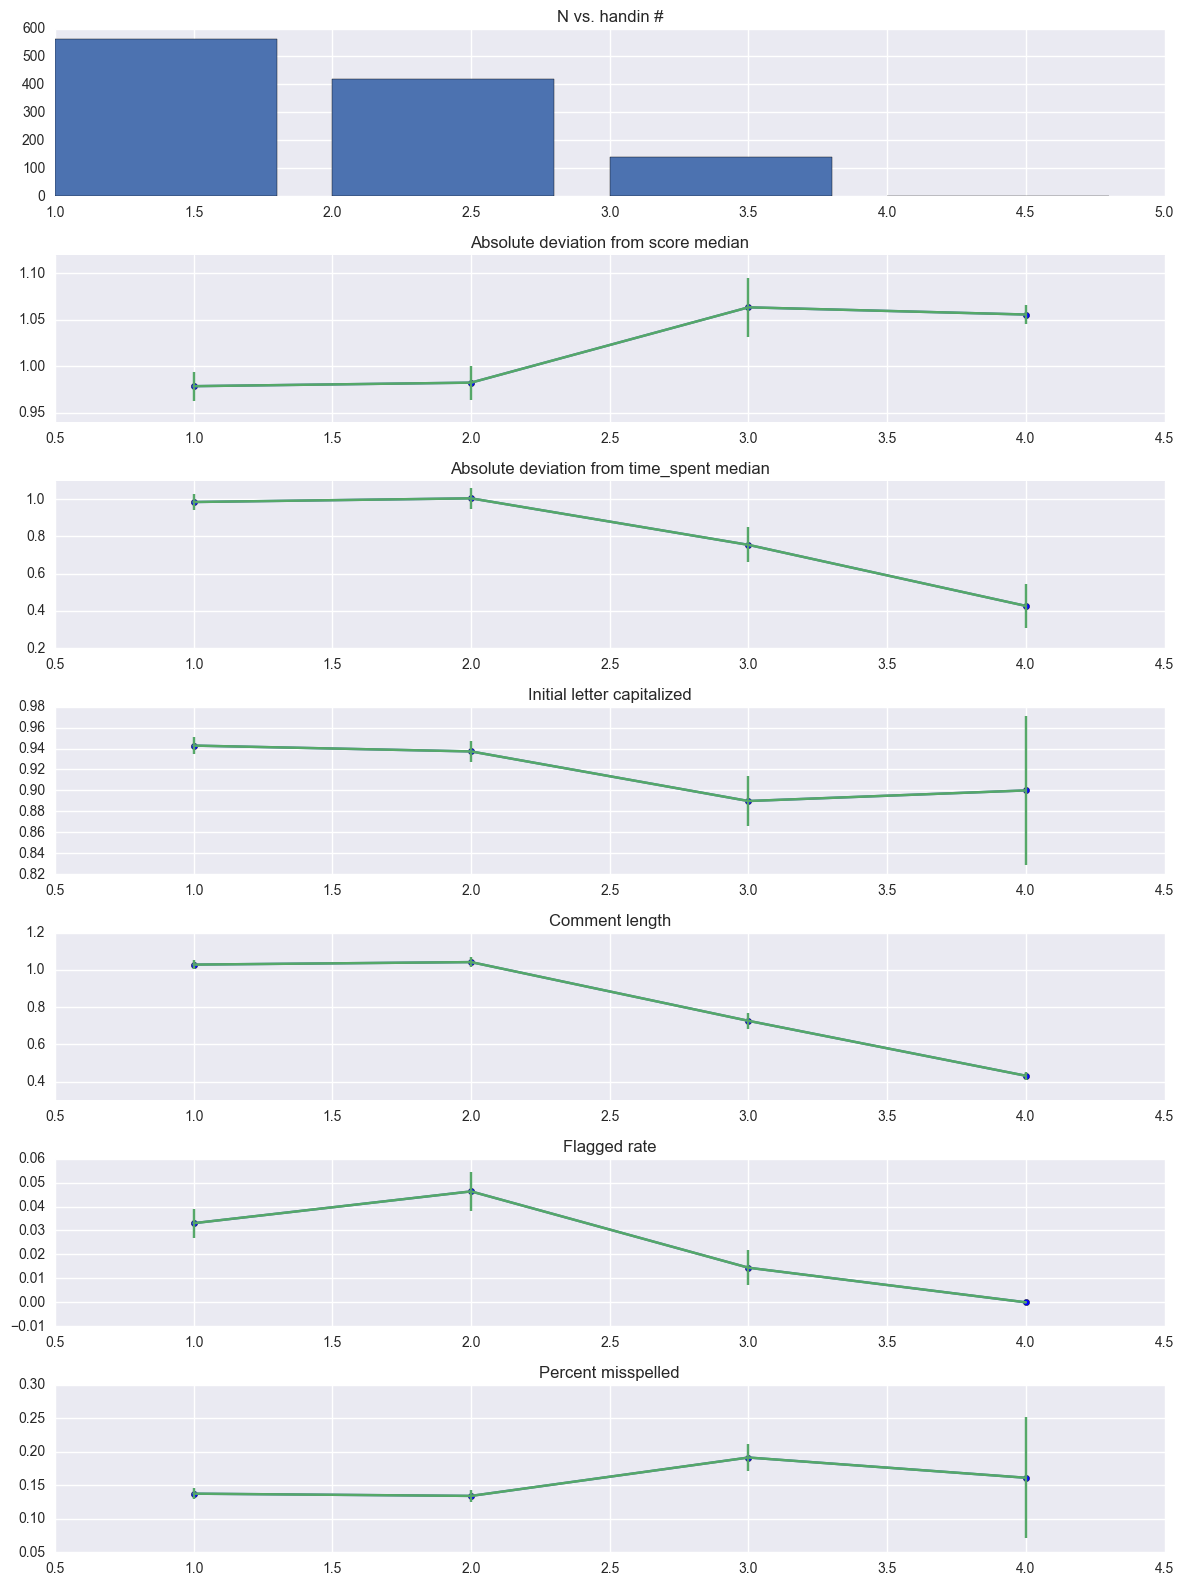

In [210]:
def no_nans(vals):
    return [v for v in vals if not np.isnan(v)]

nplots = 7
npoints = len(x1)+1
c = 1

plt.figure(figsize=(12,16))

plt.subplot(nplots, 1, c)
plt.title("N vs. handin #")
plt.bar(range(1, npoints), [len(x1[i]) for i in range(1, npoints)])

c+=1

plt.subplot(nplots, 1, c)
plt.title("Absolute deviation from score median")
data = [(no_nans(x1[i])) for i in range(1, npoints)]
x, y = range(1, npoints), [np.mean(d) for d in data]
plt.plot(x, y)
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[np.std(d)/np.sqrt(len(d)) for d in data])

c += 1

plt.subplot(nplots, 1, c)
plt.title("Absolute deviation from time_spent median")
data = [(no_nans(x2[i])) for i in range(1, npoints)]
x, y = range(1, npoints), [np.mean(d) for d in data]
plt.plot(x, y)
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[np.std(d)/np.sqrt(len(d)) for d in data])

c += 1

plt.subplot(nplots, 1, c)
plt.title("Initial letter capitalized")
data = [(no_nans(x3[i])) for i in range(1, npoints)]
x, y = range(1, npoints), [np.mean(d) for d in data]
plt.plot(x, y)
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[np.std(d)/np.sqrt(len(d)) for d in data])

c += 1

plt.subplot(nplots, 1, c)
plt.title("Comment length")
data = [(no_nans(x4[i])) for i in range(1, npoints)]
x, y = range(1, npoints), [np.mean(d) for d in data]
plt.plot(x, y)
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[np.std(d)/np.sqrt(len(d)) for d in data])

c += 1

plt.subplot(nplots, 1, c)
plt.title("Flagged rate")
data = [(no_nans(x5[i])) for i in range(1, npoints)]
x, y = range(1, npoints), [np.mean(d) for d in data]
plt.plot(x, y)
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[np.std(d)/np.sqrt(len(d)) for d in data])

c += 1

plt.subplot(nplots, 1, c)
plt.title("Percent misspelled")
data = [(no_nans(x6[i])) for i in range(1, npoints)]
x, y = range(1, npoints), [np.mean(d) for d in data]
plt.plot(x, y)
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[np.std(d)/np.sqrt(len(d)) for d in data])

plt.tight_layout()
plt.show()

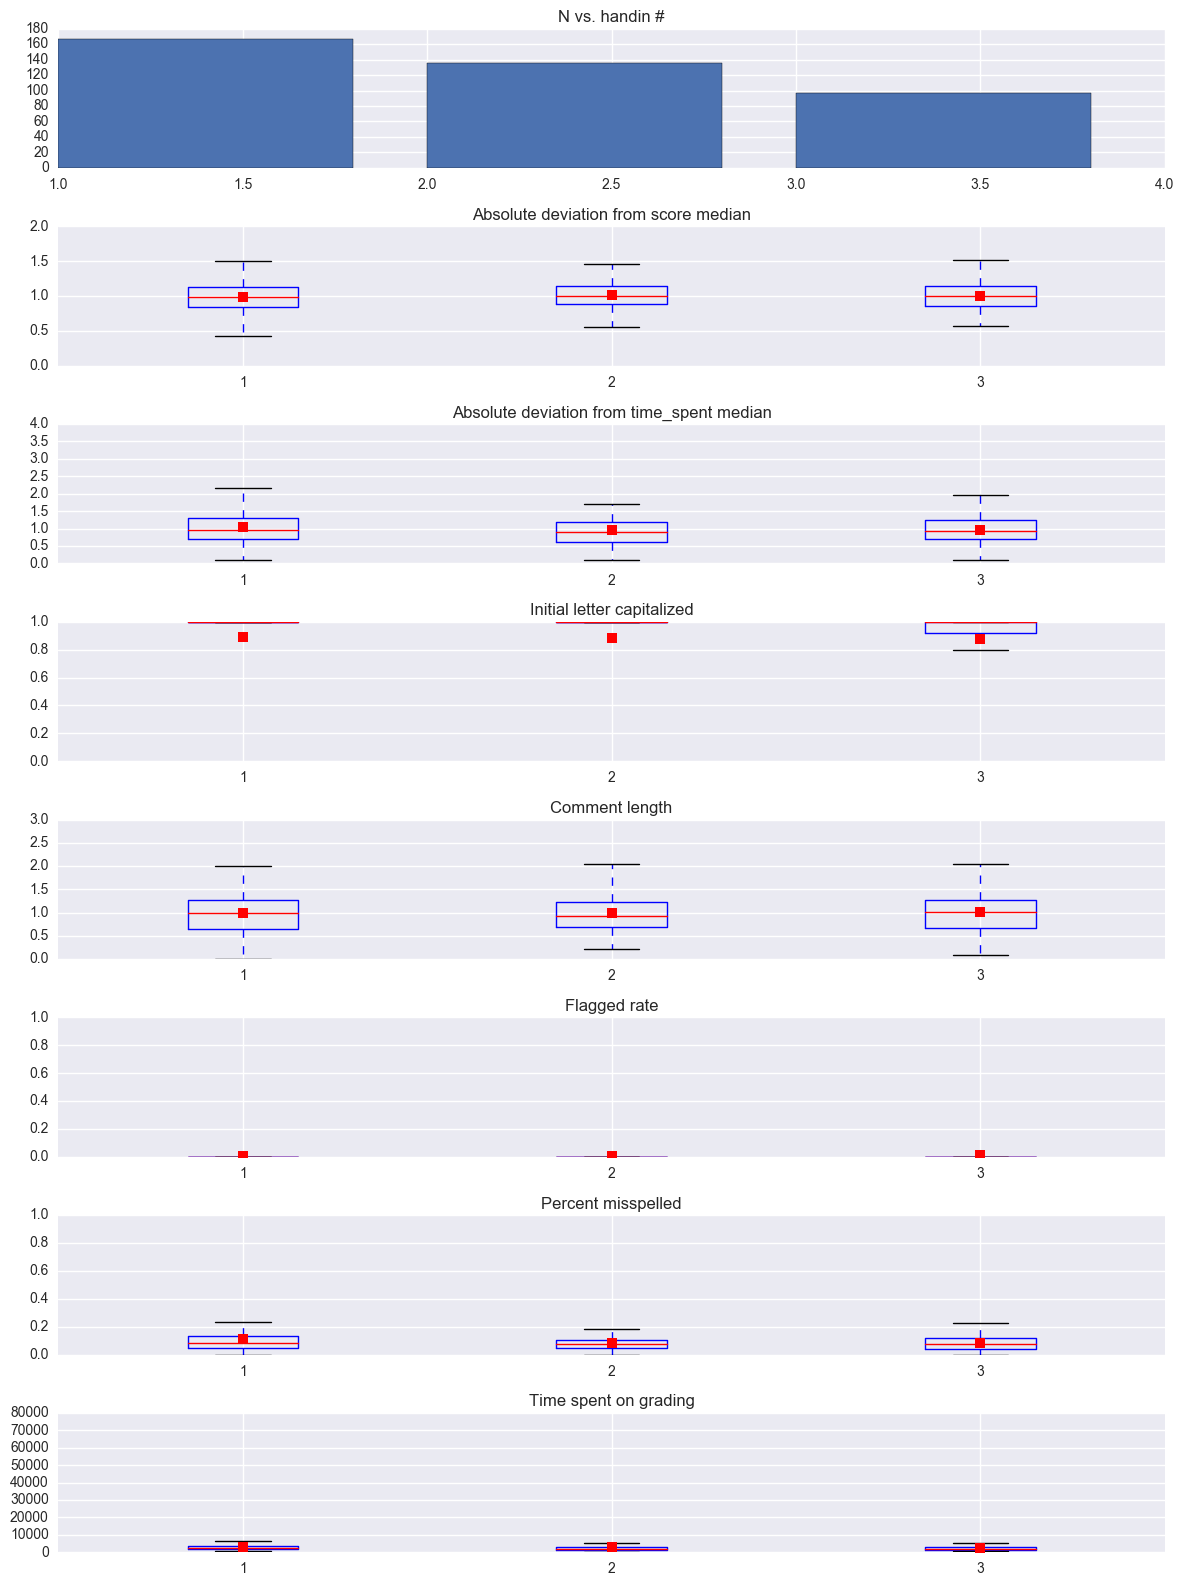

In [200]:
def no_nans(vals):
    return [v for v in vals if not np.isnan(v)]

nplots = 8
npoints = len(x1)+1

c = 1

plt.figure(figsize=(12,16))
plt.title(course, fontsize=20)

plt.subplot(nplots, 1, c)
plt.title("N vs. handin #")
plt.bar(range(1, npoints), [len(x1[i]) for i in range(1, npoints)])

c+=1

plt.subplot(nplots, 1, c)
plt.title("Absolute deviation from score median")
data = [np.array(no_nans(x1[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)

c+=1

plt.subplot(nplots, 1, c)
plt.title("Absolute deviation from time_spent median")
data = [np.array(no_nans(x2[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)

c+=1

plt.subplot(nplots, 1, c)
plt.title("Initial letter capitalized")
data = [np.array(no_nans(x3[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)

c+=1

plt.subplot(nplots, 1, c)
plt.title("Comment length")
data = [np.array(no_nans(x4[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)

c+=1

plt.subplot(nplots, 1, c)
plt.title("Flagged rate")
data = [np.array(no_nans(x5[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)

c+=1

plt.subplot(nplots, 1, c)
plt.title("Percent misspelled")
data = [np.array(no_nans(x6[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)
c+=1

plt.subplot(nplots, 1, c)
plt.title("Time spent on grading")
data = [np.array(no_nans(x7[i])) for i in range(1, npoints)]
plt.boxplot(data, showmeans=True)

plt.tight_layout()
plt.show()

## Redo

In [290]:
def get_mean_scores(_id):
    def _normalization(__id):
        return max(map(int, db['question'].find({'_id': __id}).next()['numericalAnswers'].keys())) * 1.0
    scores = []
    time_spent = []
    for report_grade in db['report_grade'].find({"handin": handin['_id']}):
        if 'time_spent' in report_grade:
            time_spent.append(report_grade['time_spent'])
        for answer in db['answer'].find({"report_grade": report_grade["_id"]}):
            if 'numerical_answer' in answer:
                scores.append(answer['numerical_answer'] / _normalization(answer["question"]))
            if 'boolean_answer' in answer:
                scores.append(1 if answer['boolean_answer'] else 0)
    return np.mean(scores), np.mean(time_spent)

ds_handin_scores = defaultdict(float)
ds_handin_time_spent = defaultdict(float)

for handin in db['handin'].find():
    mean_score, mean_time_spent = get_mean_scores(handin["_id"])
    if not np.isnan(mean_score):
        ds_handin_scores[str(handin['_id'])] = mean_score
    if not np.isnan(mean_time_spent):
        ds_handin_time_spent[str(handin['_id'])] = mean_time_spent

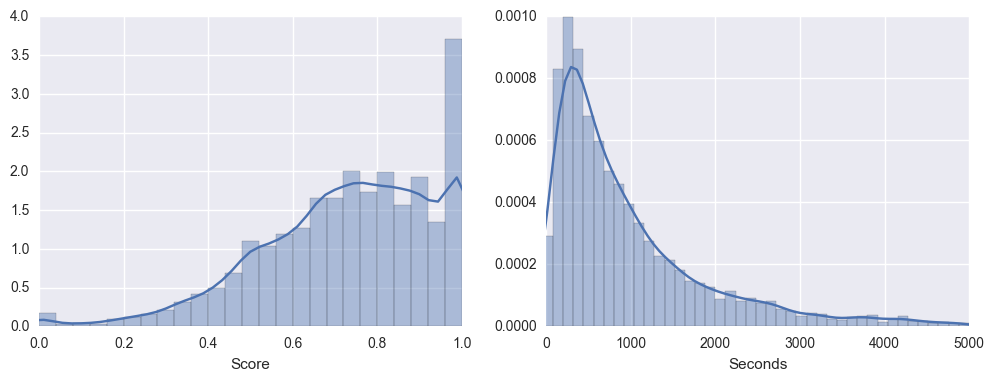

In [296]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.distplot(ds_handin_scores.values())
plt.xlabel("Score")
plt.xlim([0, 1])

plt.subplot(1,2,2)
maxval = 5000
sns.distplot([v for v in ds_handin_time_spent.values() if v < maxval])
plt.xlabel("Seconds")
plt.xlim([0, maxval])

plt.show()

In [316]:
def is_capital(c):
    """Check if character is capital"""
    return c == c.upper()

def typo_rate(sentence):
    """Fraction if words in sentence that are typos."""
    return np.mean([not d_en.check(w) for w in sentence.split()])

def number_corrected(report_grade):
    """Return report_grade's place in sequence of peergradings."""
    query = {
        "giver": report_grade['giver'],
        "handin": report_grade['handin']
    }
    return sorted(
        [r for r in db['report_grade'].find(query)],
        key=lambda r: r['_id'].generation_time
    ).index(report_grade)

dat = []

query = {
    #"submitted_at": {"$exists": True}
}

for assignment in db['assignment'].find(query):
    breakit = False
    for handin in db['handin'].find({"assignment": assignment['_id']}):
        for report_grade in db['report_grade'].find({"handin": handin['_id']}):
            
            # Aggregate answer data
            numerical_answer = []
            boolean_answer = []
            text_answer = []
            flagged = []
            
            for answer in db['answer'].find({"report_grade": report_grade['_id']}):
                if 'numerical_answer' in answer:
                    numerical_answer.append(
                        answer['numerical_answer'] * 1.0 / \
                        ds_handin_scores[str(handin['_id'])]
                    )
                if 'boolean_answer' in answer:
                    boolean_answer.append(answer['boolean_answer'])
                if 'text_answer' in answer:
                    text_answer.append(answer['text_answer'])
                # No if because format 'flagged' is inconsistent in DB
                flagged.append(_flagged(answer))
            
            # Compute various metrics
            average_score = (np.mean(numerical_answer) + np.mean(boolean_answer)) / 2.0
            average_t_len = np.mean([len(t) for t in text_answer])
            average_t_cap = np.mean([1 if is_capital(t[0]) else 0 for t in text_answer if t != ''])
            average_t_typ = np.mean([typo_rate(t) for t in text_answer if t != ''])
            average_flagg = np.mean(flagged)
            
            dat.append(
                (
                    number_corrected(report_grade),
                    (
                        average_score,
                        average_t_len,
                        average_t_cap,
                        average_t_typ,
                        average_flagg
                    )
                )
            )
    
    break

In [318]:
Counter([d[0] for d in dat])

Counter({0: 500})

In [311]:
sorted(
    [r for r in db['report_grade'].find({"giver": report_grade['giver'], "handin": report_grade['handin']})],
    key=lambda r: r['_id'].generation_time
    )

[{u'_id': ObjectId('560a7dfc774b71000fd364a0'),
  u'assignment': ObjectId('55f277cff3bd61000a2112d4'),
  u'feedback_grade': 5,
  u'flagged': False,
  u'giver': ObjectId('55db3833edf3950009412132'),
  u'handin': ObjectId('5608e19c898536000fe40a19'),
  u'state': u'ANSWERED'}]

In [307]:
print numerical_answer
print boolean_answer
print text_answer 
print flagged 
print
print "average_score", average_score
print "average_t_len", average_t_len
print "average_t_cap", average_t_cap
print "average_t_typ", average_t_typ
print "average_flagg", average_flagg

[4.4689655172413794, 2.9793103448275864, 4.4689655172413794, 0.0, 0.0, 2.9793103448275864, 2.9793103448275864, 2.9793103448275864, 2.9793103448275864, 2.9793103448275864, 4.4689655172413794, 0.0, 2.9793103448275864, 2.9793103448275864, 4.4689655172413794]
[True, True, True, True, False, False, True, True, True, True, False, True]
[u'Clear concise and working solutions', u'Exercises missing', u'', u'', u'Good solution was close to giving 3', u'', u'', u'', u'', u'', u'', u'']
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]

average_score 1.76534482759
average_t_len 7.25
average_t_cap 1.0
average_t_typ 0.0
average_flagg 0.0


In [242]:
sum(flagged)

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [226]:
breakit

False